In [1]:
from fnet import FeedForwardNet
import numpy as np
import torch
import crocoddyl
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def random_positions(size:int = 3000,
                         xlim = [-2.1,2.1],
                         ylim = [-2.1,2.1],
                         zlim = [-np.pi/2,np.pi/2],
                         as_tensor:bool = False):
    """
    Generate randomly sampled x, y, z from the ranges given.
    @params:
        1: size      = size of the array to generate
        2: xlim      = range of x positions
        3: ylim      = range of y positions
        4: zlim      = range of z positions
        5: as_tensor = bool, True if data is needed in the form of tensors
        
    @returns:
        1: dataset = [x, y, theta], where x, y, theta have been generated randomly
    
    """

    x = np.random.uniform(*xlim, size = (size, 1))
    y = np.random.uniform(*ylim, size = (size, 1))
    z = np.random.uniform(*zlim, size = (size, 1))
    
    dataset = np.hstack((x, y, z))
    
    if as_tensor:
        dataset = torch.tensor(dataset, dtype = torch.float32)
        return dataset
    
    else: return dataset


In [3]:
def train_data(dataset):
    
    trajectory = []
    
    for data in dataset:
        model = crocoddyl.ActionModelUnicycle()
        model.costWeights = np.array([1., 1.]).T
        
        problem = crocoddyl.ShootingProblem(data, [model] * 30, model)
        
        ddp = crocoddyl.SolverDDP(problem)
        
        ddp.solve([], [], 1000)
        xs = np.array(ddp.xs)
        xs = xs.flatten()
        trajectory.append(xs)
        
    return np.array(trajectory)

In [4]:
dataset = random_positions(10000)

In [5]:
trajectories = train_data(dataset)

In [6]:
xtrain   = torch.tensor(dataset, dtype = torch.float32)
ytrain   = torch.tensor(trajectories, dtype = torch.float32)

In [7]:
net = FeedForwardNet(fc1_dims=20, fc2_dims=20,input_dims=xtrain.shape[1], out_dims=ytrain.shape[1])

In [8]:
# Dataloader
dataset = torch.utils.data.TensorDataset(xtrain, ytrain)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 500)

criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3, weight_decay=0.1)  


net.train()

FeedForwardNet(
  (activation): Tanh()
  (fc1): Linear(in_features=3, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=93, bias=True)
)

In [9]:
for epoch in tqdm(range(10000)):        
        for data, target in dataloader: 

            output = net(data)
            loss = criterion(output, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


100%|██████████| 10000/10000 [10:52<00:00, 15.32it/s]


In [23]:
starting_position = random_positions(10)

In [24]:
model = crocoddyl.ActionModelUnicycle()
model.costWeights = np.array([1,1.]).T

T  = 30
problem = crocoddyl.ShootingProblem(starting_position[0], [ model ] * T, model)
with torch.no_grad():
    test = torch.tensor(starting_position[0], dtype = torch.float32).reshape(1,3)
    warm_xs = net(test).detach().numpy().reshape(31, 3)
    
ddp = crocoddyl.SolverDDP(problem)
log = crocoddyl.CallbackLogger()
ddp.setCallbacks([log,
                  crocoddyl.CallbackVerbose()])
ddp.solve(warm_xs, [], 1000)

log1 = log.stops[1:]


In [25]:
del model, problem, ddp, T, log, warm_xs

model = crocoddyl.ActionModelUnicycle()
model.costWeights = np.array([1,1.]).T

T  = 30
problem = crocoddyl.ShootingProblem(starting_position[1], [ model ] * T, model)
with torch.no_grad():
    test = torch.tensor(starting_position[1], dtype = torch.float32).reshape(1,3)
    warm_xs = net(test).detach().numpy().reshape(31, 3)
    
ddp = crocoddyl.SolverDDP(problem)
log = crocoddyl.CallbackLogger()
ddp.setCallbacks([log,
                  crocoddyl.CallbackVerbose()])
ddp.solve(warm_xs, [], 1000)

log2 = log.stops[1:]
###############################################3
del model, problem, ddp, T, log, warm_xs

model = crocoddyl.ActionModelUnicycle()
model.costWeights = np.array([1,1.]).T

T  = 30
problem = crocoddyl.ShootingProblem(starting_position[2], [ model ] * T, model)
with torch.no_grad():
    test = torch.tensor(starting_position[2], dtype = torch.float32).reshape(1,3)
    warm_xs = net(test).detach().numpy().reshape(31, 3)
    
ddp = crocoddyl.SolverDDP(problem)
log = crocoddyl.CallbackLogger()
ddp.setCallbacks([log,
                  crocoddyl.CallbackVerbose()])
ddp.solve(warm_xs, [], 1000)

log3 = log.stops[1:]
###########################################################
del model, problem, ddp, T, log, warm_xs

model = crocoddyl.ActionModelUnicycle()
model.costWeights = np.array([1,1.]).T

T  = 30
problem = crocoddyl.ShootingProblem(starting_position[3], [ model ] * T, model)
with torch.no_grad():
    test = torch.tensor(starting_position[3], dtype = torch.float32).reshape(1,3)
    warm_xs = net(test).detach().numpy().reshape(31, 3)
    
ddp = crocoddyl.SolverDDP(problem)
log = crocoddyl.CallbackLogger()
ddp.setCallbacks([log,
                  crocoddyl.CallbackVerbose()])
ddp.solve(warm_xs, [], 1000)

log4 = log.stops[1:]
############################################################

Text(0.5, 1.0, 'Different Starting Positions for Crocoddyl. Warmstarted by Neural Net.')

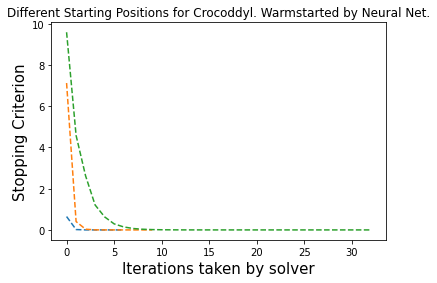

In [26]:
plt.clf()
plt.plot(log1, "--")
plt.plot(log2, '--')
plt.plot(log3, '--')
#plt.plot(log4, '--')
plt.ylabel("Stopping Criterion", fontsize = 15)
plt.xlabel("Iterations taken by solver", fontsize = 15)
plt.title("Different Starting Positions for Crocoddyl. Warmstarted by Neural Net.")
#plt.savefig("plot2_warmstarted.png")

In [27]:
model = crocoddyl.ActionModelUnicycle()
model.costWeights = np.array([1,1.]).T

T  = 30
problem = crocoddyl.ShootingProblem(starting_position[1], [ model ] * T, model)
with torch.no_grad():
    test = torch.tensor(starting_position[2], dtype = torch.float32).reshape(1,3)
    warm_xs = net(test).detach().numpy().reshape(31, 3)
    
ddp = crocoddyl.SolverDDP(problem)
log = crocoddyl.CallbackLogger()
ddp.setCallbacks([log,
                  crocoddyl.CallbackVerbose()])
ddp.solve(warm_xs, [], 1000)

log3 = log.stops[1:]

In [28]:
xs = np.array(ddp.xs)

In [29]:
del model, log, T, problem, ddp
model = crocoddyl.ActionModelUnicycle()
model.costWeights = np.array([1,1.]).T

T  = 30
problem = crocoddyl.ShootingProblem(starting_position[1], [ model ] * T, model)

ddp = crocoddyl.SolverDDP(problem)
log = crocoddyl.CallbackLogger()
ddp.setCallbacks([log,
                  crocoddyl.CallbackVerbose()])
ddp.solve([], [], 1000)

xs2 = np.array(ddp.xs)

<Figure size 432x288 with 0 Axes>

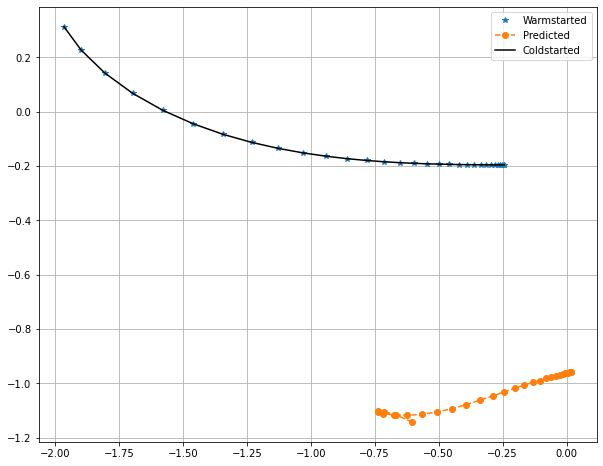

In [30]:
plt.clf()
plt.figure(figsize=(10, 8))
plt.plot(xs[:,0], xs[:,1], '*', label = "Warmstarted")
plt.plot(warm_xs[:,0], warm_xs[:,1], '--o', label = "Predicted")
plt.plot(xs2[:,0], xs2[:,1], c = 'black', label = "Coldstarted")
#plt.xlim([-2.5, 2.5]) 
#plt.ylim([2, 0]) 
plt.grid()
plt.legend()
#plt.savefig("plot5.png")

In [18]:
np.mean(warm_xs[:,0] - xs2[:,0])

-0.20664758290861282

In [19]:
np.mean(warm_xs[:,1] - xs2[:,1])

-1.5127112900799942

In [20]:
np.mean(warm_xs - xs2)

-0.4711139023904301

In [21]:
np.mean(np.abs((xs2[:,1] - warm_xs[:,1]) / xs2[:,1])) * 100

229.89497154322626

In [22]:
np.mean(np.abs((xs2[:,0] - warm_xs[:,0]) / xs2[:,0])) * 100

77.24022023953943